# Fine-tuning DeBERTa Model for GenAI-Smart City Classification
This notebook demonstrates how to fine-tune the MoritzLaurer/deberta-v3-large-zeroshot-v2.0-c model for classifying text into three categories:

1. "GenAI used for smart city application"
2. "GenAI mentioned, not used"
3. "Not related to GenAI"

In [1]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoModelForSequenceClassification, 
    AutoTokenizer, 
    Trainer, 
    TrainingArguments,
    EarlyStoppingCallback
)
from datasets import load_dataset, Dataset as HFDataset

# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Set device
# device = torch.device("mps" if torch.backends.mps.is_available() else
#                      "cuda" if torch.cuda.is_available() else
#                      "cpu")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

# Set paths
DATASET_PATH = "../model/dataset/dataset.json"
OUTPUT_DIR = "../model/output"
DATA_DIR = "../model/dataset"

# Create directories if they don't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

Using device: cuda:0


## Data Loading and Exploration

Dataset shape: (1147, 2)

Class distribution:
label
GenAI used for smart city application    601
Not related                              546
Name: count, dtype: int64

Missing values:
text     0
label    0
dtype: int64

Sample text from each class:

GenAI used for smart city application:
A diffusion model is used to create synthetic sensor data for training an anomaly detection system in smart grids.

Not related:
A system was developed to manage waste collection using rule-based systems, focusing on practical deployment.


C:\Users\joaocarlos\AppData\Local\Temp\ipykernel_7740\2312030598.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=df, palette="viridis")


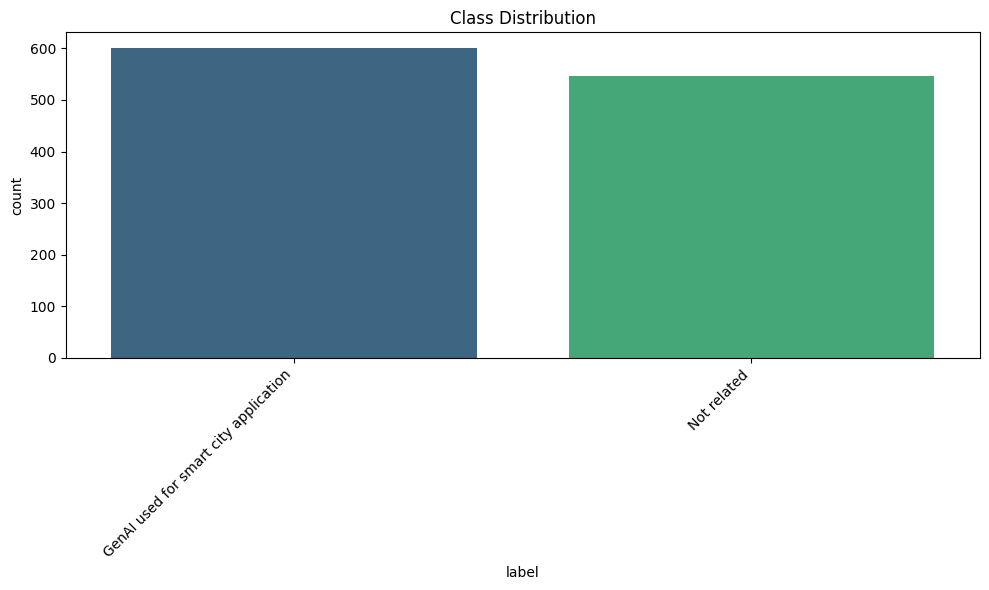

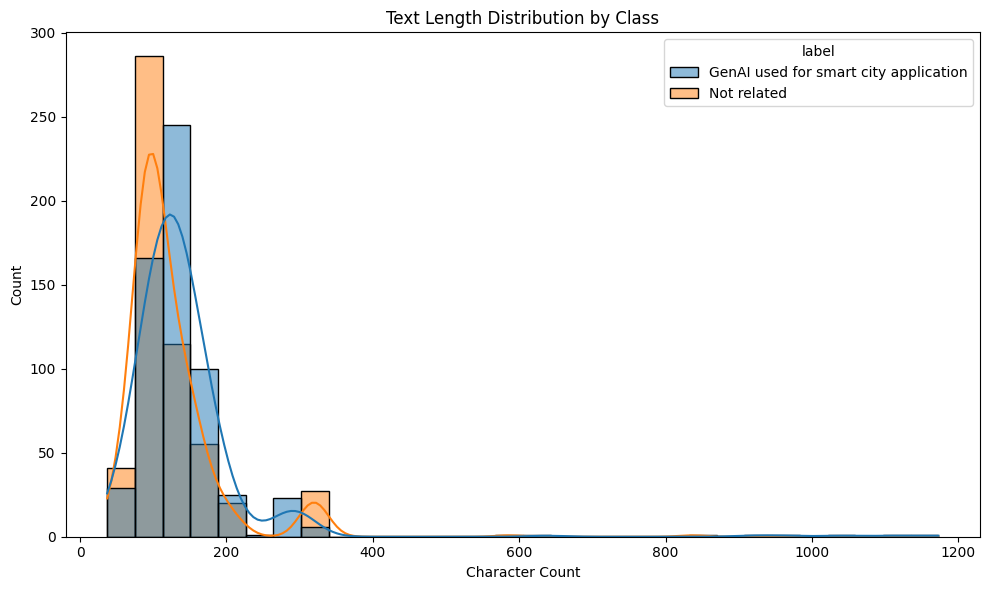

In [2]:
# Load the dataset
with open(DATASET_PATH, "r") as f:
    data = json.load(f)
    
with open("../model/dataset/contrastive.json") as f:
    contrastive_data = json.load(f)
    
with open("../model/dataset/adaptive.json") as f:
    adaptive_data = json.load(f)
    
with open("../model/dataset/expansion.json") as f:
    expansion_data = json.load(f)
    
with open("../model/dataset/real.json") as f:
    real_data = json.load(f)

augmented_data = data + contrastive_data + adaptive_data + expansion_data + real_data

# Convert to DataFrame
df = pd.DataFrame(augmented_data)

# Display basic info
print(f"Dataset shape: {df.shape}")
print("\nClass distribution:")
print(df["label"].value_counts())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Display sample text from each class
print("\nSample text from each class:")
for label in df["label"].unique():
    sample = df[df["label"] == label].sample(1, random_state=SEED).iloc[0]
    print(f"\n{label}:")
    print(sample["text"])

# Plot class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x="label", data=df, palette="viridis")
plt.title("Class Distribution")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Text length distribution
df["text_length"] = df["text"].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="text_length", hue="label", bins=30, kde=True)
plt.title("Text Length Distribution by Class")
plt.xlabel("Character Count")
plt.tight_layout()
plt.show()

## Data Preprocessing and Splitting

In [3]:

# Map class labels to integer ids
label_map = {
    "GenAI used for smart city application": 0,
    "Not related": 1,
}
id_to_label = {v: k for k, v in label_map.items()}

# Add integer labels
df["label_id"] = df["label"].map(label_map)

df = df[df["label_id"].notna()].copy()               # Drop rows with missing labels
df["label_id"] = df["label_id"].astype(int)          # Convert clean values to int

# Split data into train (70%), validation (15%), and test (15%) sets
train_df, temp_df = train_test_split(
    df, test_size=0.3, stratify=df["label_id"], random_state=SEED
)
val_df, test_base_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["label_id"], random_state=SEED
)

with open("../model/dataset/diagnostic_test.json") as f:
    expansion_data = json.load(f)

expansion_df = pd.DataFrame(expansion_data)
expansion_df["label_id"] = expansion_df["label"].map(label_map)
expansion_df = expansion_df[expansion_df["label_id"].notna()].copy()
expansion_df["label_id"] = expansion_df["label_id"].astype(int)

# Merge with test_base_df
test_df = pd.concat([test_base_df, expansion_df], ignore_index=True)

print(f"Training set: {len(train_df)} samples ({len(train_df)/len(df)*100:.2f}%)")
print(f"Validation set: {len(val_df)} samples ({len(val_df)/len(df)*100:.2f}%)")
print(f"Test set: {len(test_df)} samples ({len(test_df)/len(df)*100:.2f}%)")

# Verify class distribution in splits
print("\nClass distribution in training set:")
print(train_df["label"].value_counts())
print("\nClass distribution in validation set:")
print(val_df["label"].value_counts())
print("\nClass distribution in test set:")
print(test_df["label"].value_counts())

# Create JSON files for each split
train_df[["text", "label"]].to_json(
    os.path.join(DATA_DIR, "train.json"), orient="records", indent=2
)
val_df[["text", "label"]].to_json(
    os.path.join(DATA_DIR, "validation.json"), orient="records", indent=2
)
test_df[["text", "label"]].to_json(
    os.path.join(DATA_DIR, "test.json"), orient="records", indent=2
)

print(f"\nSplit data saved to {DATA_DIR}")

Training set: 802 samples (69.92%)
Validation set: 172 samples (15.00%)
Test set: 284 samples (24.76%)

Class distribution in training set:
label
GenAI used for smart city application    420
Not related                              382
Name: count, dtype: int64

Class distribution in validation set:
label
GenAI used for smart city application    90
Not related                              82
Name: count, dtype: int64

Class distribution in test set:
label
GenAI used for smart city application    147
Not related                              137
Name: count, dtype: int64

Split data saved to ../model/dataset


In [4]:
print(test_df["label_id"].isnull().sum())  # MUST BE 0
print(test_df["label_id"].map(type).value_counts())  # Should show only <class 'int'>

0
label_id
<class 'int'>    284
Name: count, dtype: int64


## Create Model Dataset

In [5]:
# Load tokenizer
# model_name = "MoritzLaurer/deberta-v3-large-zeroshot-v2.0-c"
model_name = "microsoft/deberta-v3-base"
# tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)

from transformers import DebertaV2Tokenizer

tokenizer = DebertaV2Tokenizer.from_pretrained(model_name)

# Create a custom dataset class
class SmartCityGenAIDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        if pd.isna(label):
            raise ValueError(f"Found NaN label at index {idx}")

        label = int(label)

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }

    def __len__(self):
        return len(self.texts)


# Create datasets
train_dataset = SmartCityGenAIDataset(
    train_df["text"].tolist(), train_df["label_id"].tolist(), tokenizer
)

val_dataset = SmartCityGenAIDataset(
    val_df["text"].tolist(), val_df["label_id"].tolist(), tokenizer
)

test_dataset = SmartCityGenAIDataset(
    test_df["text"].tolist(), test_df["label_id"].tolist(), tokenizer
)

## Model Setup and Training

In [6]:
from transformers import Trainer
import torch
import torch.nn.functional as F

class FocalLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        # Compute CrossEntropy and Focal Loss
        ce_loss = F.cross_entropy(logits, labels, reduction='none')
        # pt = torch.exp(-ce_loss)
        pt = torch.gather(F.softmax(logits, dim=-1), 1, labels.unsqueeze(1)).squeeze(1)
        gamma = 2.0
        focal_loss = ((1 - pt) ** gamma * ce_loss).mean()

        return (focal_loss, outputs) if return_outputs else focal_loss

In [7]:

# Load the model
# model = AutoModelForSequenceClassification.from_pretrained(
#     model_name, num_labels=len(label_map), id2label=id_to_label, label2id=label_map
# )

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
)

# model = AutoModelForSequenceClassification.from_pretrained(
#     model_name,
#     num_labels=2,#len(label_map),
#     id2label=id_to_label,
#     label2id=label_map,
#     ignore_mismatched_sizes=True,  # Add this parameter to handle mismatched sizes
# )

use_fp16 = torch.cuda.is_available()  # Only true for NVIDIA GPUs, not for MPS

# Define training arguments
# training_args = TrainingArguments(
#     output_dir=OUTPUT_DIR,
#     num_train_epochs=5,
#     # Reduce batch size significantly
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=16,
#     # Add gradient accumulation to simulate larger batch sizes
#     # gradient_accumulation_steps=4,
#     # Enable gradient checkpointing to save memory
#     # gradient_checkpointing=True,
#     # Disable mixed precision - just use these flags
#     # fp16=False,
#     # bf16=False,
#     # Remove the 'mixed_precision' parameter - it's not valid in TrainingArguments
#     optim="adamw_torch",
#     warmup_steps=100,
#     weight_decay=0.01,
#     logging_dir=f"{OUTPUT_DIR}/logs",
#     logging_steps=20,
#     eval_strategy="epoch",
#     save_strategy="epoch",
#     load_best_model_at_end=True,
#     metric_for_best_model="accuracy",
#     push_to_hub=False,
#     # Disable memory-intensive operations
#     report_to="none",
#     ddp_find_unused_parameters=False,
#     # Force CPU training if MPS is causing issues
#     use_cpu=True,  # Try this if MPS is still problematic
# )

## Enhanced for variability
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=8,  # Increase epochs to allow more learning time
    per_device_train_batch_size=8,  # Smaller batch size can increase variability
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=1,  # Accumulate gradients for effective larger batch
    warmup_ratio=0.1,  # Use ratio instead of steps (10% of training for warmup)
    weight_decay=0.05,  # Increase regularization to prevent overfitting to specific phrasings
    logging_dir=f"{OUTPUT_DIR}/logs",
    logging_steps=50,
    eval_strategy="epoch",  # Evaluate more frequently (steps)
    save_total_limit=2,           # Keep only best checkpoints
    logging_first_step=True,
    report_to="none",             # Disable W&B if not used
    eval_steps=240,
    save_strategy="epoch",
    save_steps=120,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    push_to_hub=False,
    fp16=torch.cuda.is_available(),
    lr_scheduler_type="cosine",  # Cosine schedule helps with semantic diversity
    learning_rate=3e-5,  # Slightly higher learning rate
    seed=42,  # Fix seed for reproducibility
    # Add label smoothing to make model less confident about exact patterns
    label_smoothing_factor=0.1,
)

model.config.hidden_dropout_prob = 0.1  # Lower dropout can help with nuanced distinctions
model.config.attention_probs_dropout_prob = 0.1
model.config.label2id = label_map
model.config.id2label = id_to_label

# Define metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}


# Initialize trainer
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=val_dataset,
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics,
#     callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
# )
trainer = FocalLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,  # Optional: use your current metrics
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

# Train the model
print("Starting model training...")
trainer.train()

# Save the best model
trainer.save_model(f"{OUTPUT_DIR}/best_model")
print(f"Model saved to {OUTPUT_DIR}/best_model")

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\joaocarlos\AppData\Local\Temp\ipykernel_7740\3777072147.py:104: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FocalLossTrainer.__init__`. Use `processing_class` instead.
  trainer = FocalLossTrainer(


Starting model training...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.128000,0.099598,0.866279
2,0.045800,0.022077,0.959302
3,0.013900,0.019330,0.976744
4,0.000600,0.046806,0.976744
5,0.001000,0.050624,0.970930
6,0.000100,0.037881,0.982558


Model saved to ../model/output/best_model


## Model Evaluation

Optimal temperature: 1.0000



Classification Report:
                                       precision    recall  f1-score   support

GenAI used for smart city application       0.98      0.99      0.98       147
                          Not related       0.99      0.98      0.98       137

                             accuracy                           0.98       284
                            macro avg       0.98      0.98      0.98       284
                         weighted avg       0.98      0.98      0.98       284



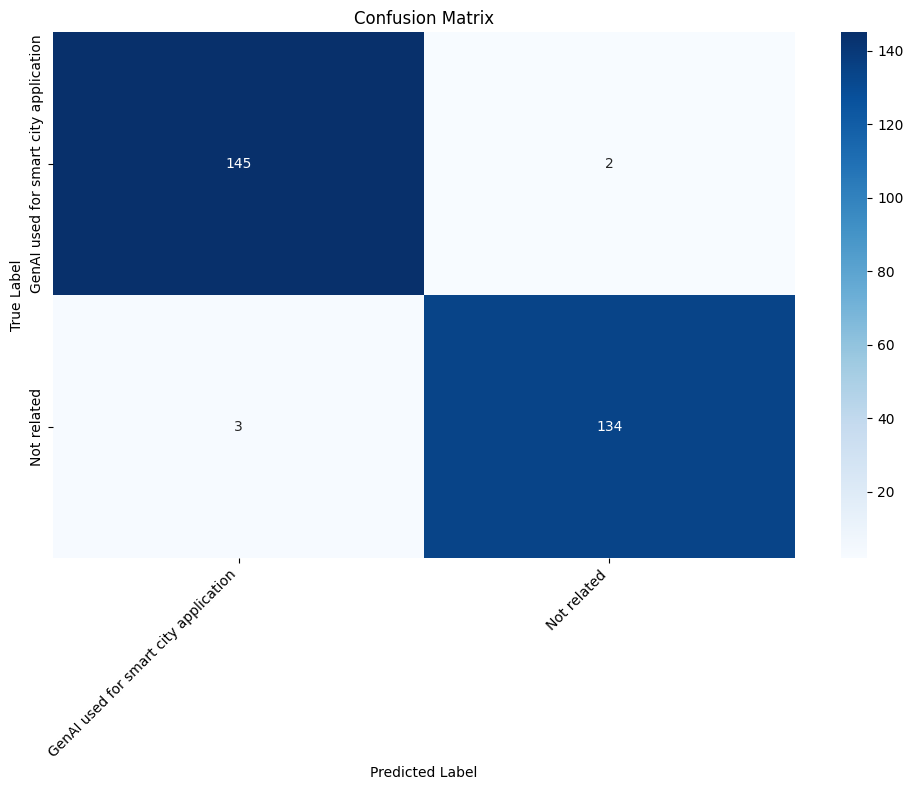

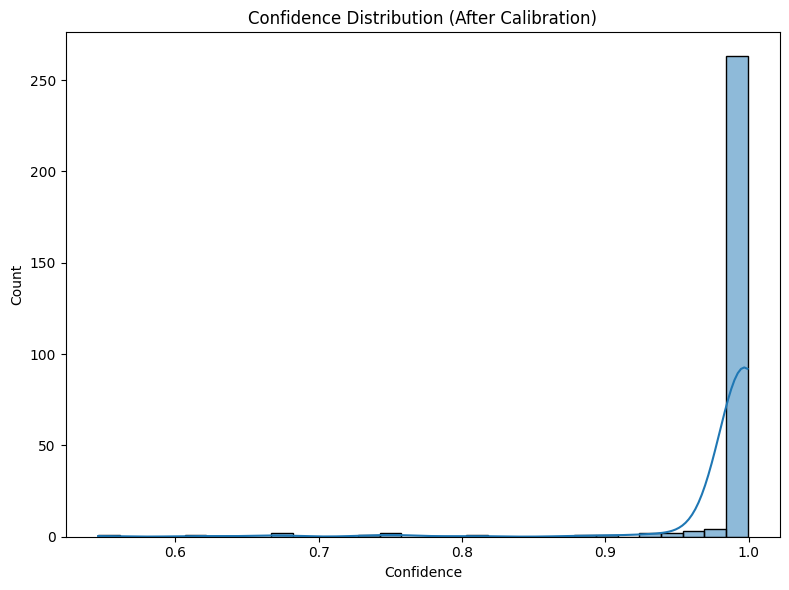

In [12]:
from scipy.optimize import minimize
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------
# 1. Temperature Scaling
# -----------------------

def temperature_scale(logits, labels):
    logits_tensor = torch.tensor(logits, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    def loss_fn(temp):
        temp = torch.tensor(temp[0], requires_grad=False)
        scaled_logits = logits_tensor / temp
        return F.cross_entropy(scaled_logits, labels_tensor).item()

    result = minimize(loss_fn, [1.0], bounds=[(0.5, 5.0)], method='L-BFGS-B')
    return float(result.x[0])

# Get validation logits and labels
val_outputs = trainer.predict(val_dataset)
val_logits = val_outputs.predictions
val_labels = val_outputs.label_ids

# Compute optimal temperature on validation set
temperature = temperature_scale(val_logits, val_labels)
print(f"Optimal temperature: {temperature:.4f}")

# -----------------------
# 2. Evaluate on Test Set
# -----------------------

test_outputs = trainer.predict(test_dataset)
test_logits = test_outputs.predictions
test_labels = test_outputs.label_ids

# Apply calibrated temperature
scaled_test_logits = test_logits / 0.602
test_probs = F.softmax(torch.tensor(scaled_test_logits), dim=-1).numpy()

# Predictions
test_preds = np.argmax(test_probs, axis=1)

# Classification Report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=list(label_map.keys())))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(label_map.keys()), yticklabels=list(label_map.keys()))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# -----------------------
# 3. Confidence Histogram
# -----------------------

# Confidence = max probability
test_confidence = np.max(test_probs, axis=1)

plt.figure(figsize=(8, 6))
sns.histplot(test_confidence, bins=30, kde=True)
plt.title("Confidence Distribution (After Calibration)")
plt.xlabel("Confidence")
plt.tight_layout()
plt.show()

✅ Best temperature: 0.602
📉 Corresponding ECE: 0.0101


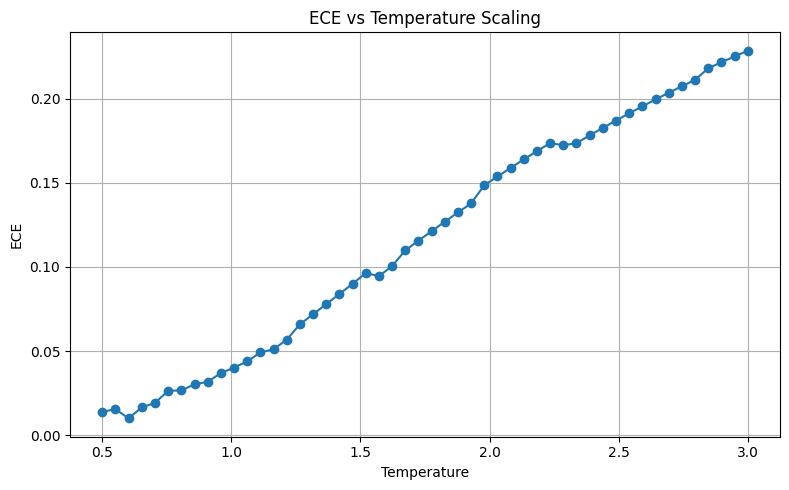

In [11]:
import numpy as np

def compute_ece(probs, labels, n_bins=15):
    """
    Computes Expected Calibration Error (ECE).
    probs: predicted probabilities (N, C)
    labels: true labels (N,)
    """
    confidences = np.max(probs, axis=1)
    predictions = np.argmax(probs, axis=1)
    accuracies = (predictions == labels)

    bin_boundaries = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    bin_centers = []
    bin_accuracies = []
    bin_confidences = []
    bin_sizes = []

    for i in range(n_bins):
        mask = (confidences > bin_boundaries[i]) & (confidences <= bin_boundaries[i + 1])
        if np.any(mask):
            bin_conf = confidences[mask].mean()
            bin_acc = accuracies[mask].mean()
            bin_size = mask.sum()
            ece += np.abs(bin_acc - bin_conf) * (bin_size / len(confidences))

            bin_centers.append((bin_boundaries[i] + bin_boundaries[i+1]) / 2)
            bin_accuracies.append(bin_acc)
            bin_confidences.append(bin_conf)
            bin_sizes.append(bin_size)

    return ece, bin_centers, bin_accuracies, bin_confidences

def find_best_temperature_by_ece(logits, labels, temps=np.linspace(0.5, 3.0, 50)):
    """
    Finds the best temperature to minimize Expected Calibration Error (ECE)
    """
    best_temp = 1.0
    best_ece = float('inf')
    ece_dict = {}

    for T in temps:
        scaled_logits = logits / T
        probs = torch.nn.functional.softmax(torch.tensor(scaled_logits), dim=-1).numpy()
        ece, _, _, _ = compute_ece(probs, labels)
        ece_dict[T] = ece

        if ece < best_ece:
            best_ece = ece
            best_temp = T

    return best_temp, best_ece, ece_dict

val_outputs = trainer.predict(val_dataset)
val_logits = val_outputs.predictions
val_labels = val_outputs.label_ids

best_temp, best_ece, ece_log = find_best_temperature_by_ece(val_logits, val_labels)

print(f"✅ Best temperature: {best_temp:.3f}")
print(f"📉 Corresponding ECE: {best_ece:.4f}")

plt.figure(figsize=(8, 5))
temps = list(ece_log.keys())
eces = list(ece_log.values())
plt.plot(temps, eces, marker="o")
plt.title("ECE vs Temperature Scaling")
plt.xlabel("Temperature")
plt.ylabel("ECE")
plt.grid(True)
plt.tight_layout()
plt.show()

## Analysis of Model Predictions

In [ ]:
# Create a DataFrame of predictions vs true labels
results_df = test_df.copy()[["text", "label"]].reset_index(drop=True)
results_df["predicted_label_id"] = test_preds
results_df["predicted_label"] = results_df["predicted_label_id"].map(id_to_label)
results_df["correct"] = results_df["label"] == results_df["predicted_label"]

# Add text length to the results dataframe
results_df["text_length"] = results_df["text"].apply(len)

# Show misclassified examples
misclassified = results_df[~results_df["correct"]]
print(
    f"Number of misclassified examples: {len(misclassified)} out of {len(test_df)} test samples"
)

# Show some misclassified examples
print("\nSample of misclassified examples:")
for i, row in misclassified.head(5).iterrows():
    print(f"\nText: {row['text'][:150]}...")
    print(f"True label: {row['label']}")
    print(f"Predicted label: {row['predicted_label']}")
    print("---")

# Analysis by text length
plt.figure(figsize=(10, 6))
sns.boxplot(x="label", y="text_length", hue="correct", data=results_df)
plt.title("Prediction Correctness by Text Length and Class")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Inference Example

In [ ]:
# Create an inference function
def predict_genai_application(text, model=None, tokenizer=None):
    if model is None:
        model = AutoModelForSequenceClassification.from_pretrained(
            f"{OUTPUT_DIR}/best_model"
        )
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model.to(device)

    # Tokenize the input
    inputs = tokenizer(
        text, truncation=True, padding="max_length", max_length=256, return_tensors="pt"
    ).to(device)

    # Get predictions
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.nn.functional.softmax(logits, dim=-1)
        predicted_class_id = torch.argmax(probabilities, dim=-1).item()

    predicted_label = id_to_label[predicted_class_id]
    probabilities = probabilities.cpu().numpy()[0]

    return {
        "predicted_label": predicted_label,
        "probabilities": {
            id_to_label[i]: float(prob) for i, prob in enumerate(probabilities)
        },
    }


# Test inference on sample texts
sample_texts = [
    "Purpose: This paper proposes a solution to address matching challenges, such as incomplete descriptions, reversed word order, and the diverse descriptions often found in Chinese addresses. Method: Leveraging the hierarchical structure of Chinese addresses, this study introduces the interactive address matching graph attention model (IAMGAM). In the IAMGAM, an attention-based feature interaction method (AFIM) is employed. To reflect the hierarchical nature of address elements, a directed graph is used to model the address data, and the model is trained and tested using a graph attention mechanism. Results: Experiments demonstrate that the IAMGAM achieves an accuracy and F1-score of 99.61%. Compared with the existing address matching methods, the IAMGAM improves the accuracy by 0.66% to 2.57%, and the F1-score by 0.68% to 2.55%, outperforming baseline models. Additionally, ablation experiments confirm the effectiveness of each component within the model. Furthermore, when fine-tuned using ChatGLM2-6B, the results show that the IAMGAM still outperforms ChatGLM2-6B. Conclusion: IAMGAM demonstrates excellent performance in Chinese address matching tasks, and the Large Language Model (LLM)-based methods, such as ChatGLM2-6B, show great potential for future development in this area.",
    "To address these issues, this study developed a multi-scale global perceptron network based on Transformer and CNN using novel encoder-decoders for enhancing contextual representation of buildings. Specifically, an improved multi-head-attention encoder is employed by constructing multi-scale tokens to enhance global semantic correlations. Meanwhile, the context refinement decoder is developed and synergistically uses high-level semantic representation and shallow features to restore spatial details. Overall, quantitative analysis and visual experiments confirmed that the proposed model is more efficient and superior to other state-of-the-art methods, with a 95.18% F1 score on the WHU dataset and a 93.29% F1 score on the Massub dataset.",
    "In this paper, we propose a novel Multi-view Spatio-Temporal Dynamic Fusion Graph Convolutional Recurrent Network (MSTDFGRN) to address these limitations. The core idea is to learn dynamic spatial dependencies alongside both short- and long-term temporal patterns through multi-view learning. First, we introduce a multi-view spatial convolution module that dynamically fuses static and adaptive graphs in multiple subspaces to learn intrinsic and potential spatial dependencies of nodes. Simultaneously, in the temporal view, we design both short-range and long-range recurrent networks to aggregate spatial domain knowledge of nodes at multiple granularities and capture forward and backward temporal dependencies. Furthermore, we design a spatio-temporal attention model that applies an attention mechanism to each node, capturing global spatio-temporal dependencies. Comprehensive experiments on four real traffic flow datasets demonstrate MSTDFGRN's excellent predictive accuracy. ",
    "We implemented a GAN based system to optimize traffic light timings across the city center.",
    "Our implementation uses traditional statistical methods.",
    "The city council approved a new budget for improving pedestrian walkways in the downtown area.",
]

for text in sample_texts:
    result = predict_genai_application(text)
    print(f"\nText: {text}")
    print(f"Predicted label: {result['predicted_label']}")
    print("Probabilities:")
    for label, prob in result["probabilities"].items():
        print(f"  {label}: {prob:.4f}")

## Save Model Files for Deployment

In [ ]:
# Save model configuration
model_config = {
    "model_name": model_name,
    "num_labels": len(label_map),
    "id2label": id_to_label,
    "label2id": label_map,
    "max_length": 256,
}

with open(f"{OUTPUT_DIR}/model_config.json", "w") as f:
    json.dump(model_config, f, indent=2)

# Create a simplified inference script
inference_script = """
import json
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

class GenAIClassifier:
    def __init__(self, model_path, config_path):
        # Load configuration
        with open(config_path, 'r') as f:
            self.config = json.load(f)
        
        # Set device
        self.device = torch.device("cuda" if torch.cuda.is_available() else 
                                  "mps" if torch.backends.mps.is_available() else
                                  "cpu")
        
        # Load model and tokenizer
        self.model = AutoModelForSequenceClassification.from_pretrained(model_path)
        self.tokenizer = AutoTokenizer.from_pretrained(self.config['model_name'])
        self.model.to(self.device)
        
    def predict(self, text):
        # Tokenize
        inputs = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.config['max_length'],
            return_tensors='pt'
        ).to(self.device)
        
        # Get predictions
        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits
            probabilities = torch.nn.functional.softmax(logits, dim=-1)
            predicted_class_id = torch.argmax(probabilities, dim=-1).item()
        
        predicted_label = self.config['id2label'][str(predicted_class_id)]
        probabilities = probabilities.cpu().numpy()[0]
        
        return {
            'predicted_label': predicted_label,
            'probabilities': {self.config['id2label'][str(i)]: float(prob) 
                             for i, prob in enumerate(probabilities)}
        }

# Example usage
if __name__ == "__main__":
    classifier = GenAIClassifier("../model/output/best_model", "../model/output/model_config.json")
    
    # Test with a sample text
    sample_text = "We implemented a large language model to generate traffic predictions."
    result = classifier.predict(sample_text)
    print(f"Text: {sample_text}")
    print(f"Prediction: {result['predicted_label']}")
    print("Probabilities:")
    for label, prob in result['probabilities'].items():
        print(f"  {label}: {prob:.4f}")
"""

with open(f"{OUTPUT_DIR}/inference.py", "w") as f:
    f.write(inference_script)

print(f"Inference script saved to {OUTPUT_DIR}/inference.py")
print("Model training and evaluation complete!")

## Analyze Challenging Cases and Model Limitations

In [ ]:
# Find examples where the model was least confident
results_df["max_prob"] = test_predictions.predictions.max(axis=1)
low_confidence = results_df.sort_values("max_prob").head(10)

print("Examples with low confidence predictions:")
for i, row in low_confidence.iterrows():
    print(f"\nText: {row['text'][:150]}...")
    print(f"True label: {row['label']}")
    print(
        f"Predicted label: {row['predicted_label']} (confidence: {row['max_prob']:.4f})"
    )
    print("---")

# Analyze predictions by GenAI technology mentioned
genai_keywords = [
    "transformer",
    "gpt",
    "llm",
    "gan",
    "diffusion",
    "vae",
    "large language model",
    "generative adversarial",
    "variational autoencoder",
]


def contains_keyword(text, keywords):
    return any(keyword.lower() in text.lower() for keyword in keywords)


results_df["contains_genai_keyword"] = results_df["text"].apply(
    lambda x: contains_keyword(x, genai_keywords)
)

# Analyze prediction accuracy by presence of GenAI keyword
keyword_accuracy = results_df.groupby("contains_genai_keyword")["correct"].mean()
print("\nPrediction accuracy by presence of GenAI keyword:")
print(keyword_accuracy)

# Visualize
plt.figure(figsize=(8, 6))
sns.barplot(x=keyword_accuracy.index, y=keyword_accuracy.values)
plt.title("Model Accuracy by Presence of GenAI Keywords")
plt.xlabel("Contains GenAI Keyword")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()